In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
import numpy as np

In [2]:
cols = ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5',
       'bio_6', 'bio_7', 'bio_8', 'bio_9', 'bio_10', 'bio_11', 'bio_12',
       'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18', 'bio_19',
       'bdticm', 'bldfie', 'cecsol', 'clyppt', 'orcdrc', 'phihox', 'sltppt',
       'sndppt']

In [3]:
hs = pd.read_csv("hotspots_data_with_bioclim.csv")

indices = np.load('/network/scratch/t/tengmeli/ecosystem-embedding/songbirds_idx.npy')

In [4]:
training = pd.read_csv("/network/scratch/t/tengmeli/ecosystem-embedding/training/train_june.csv")
#training = training.rename(columns={"hotspot": "hotspot_id"})
valid= pd.read_csv("/network/scratch/t/tengmeli/ecosystem-embedding/training/val_june.csv")

## Prepare data

In [5]:
import json

In [6]:
train = training.merge(hs, how="inner", left_on ="hotspot",right_on ="hotspot_id")
train = train.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','r','g','b','nir'])
#train.isna().sum()
val = valid.merge(hs, how="inner", left_on ="hotspot",right_on ="hotspot_id")
val = val.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','r','g','b','nir'])

## visualize missing data

In [7]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

In [8]:
train_gdf = gpd.read_file("../train_geodf.geojson")

train_gdf = train_gdf.merge(train, how = "inner",left_on= "hotspot", right_on = "hotspot")

train_gdf["missing"] = train_gdf["bio_1"].isna()

points = train_gdf.copy()

geometry  = [Point(xy) for xy in zip(points["lon_x"], points["lat_x"])]

points = gpd.GeoDataFrame(points, crs = "epsg:4326", geometry = geometry)

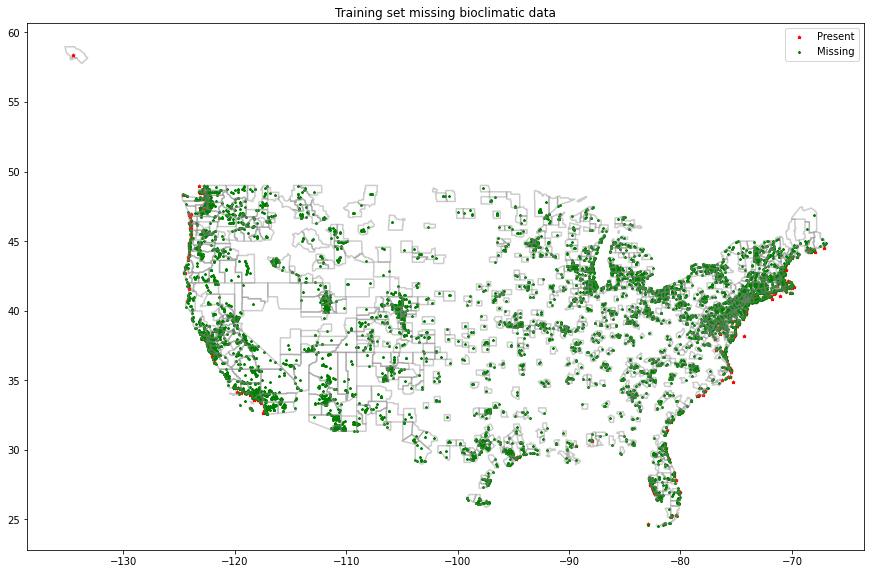

In [18]:
fig, ax = plt.subplots(figsize =(15,10))
train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
points[points['missing']].plot(ax=ax, marker='*', color='red', markersize=10, label = "Present")

points[~points['missing']].plot(ax=ax, marker='*', color='g', markersize=5, label = "Missing")
plt.legend()
plt.title("Training set missing bioclimatic data")
plt.savefig("missing_bio_train.png")
plt.show()

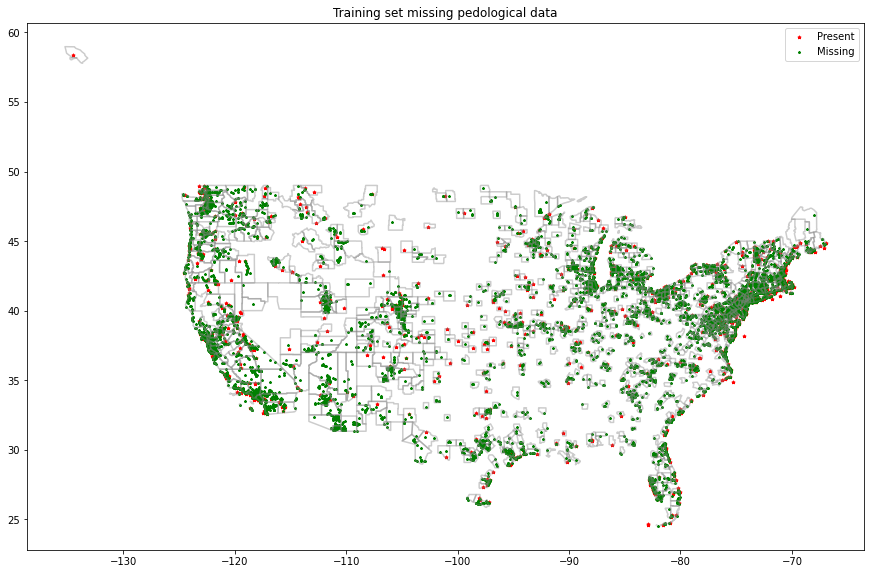

In [26]:
train_gdf = gpd.read_file("../train_geodf.geojson")

train_gdf = train_gdf.merge(train, how = "inner",left_on= "hotspot", right_on = "hotspot")

train_gdf["missing"] = train_gdf["sndppt"].isna()

points = train_gdf.copy()

geometry  = [Point(xy) for xy in zip(points["lon_x"], points["lat_x"])]

points = gpd.GeoDataFrame(points, crs = "epsg:4326", geometry = geometry)
fig, ax = plt.subplots(figsize =(15,10))
train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
points[points['missing']].plot(ax=ax, marker='*', color='red', markersize=10, label = "Present")

points[~points['missing']].plot(ax=ax, marker='*', color='g', markersize=5, label = "Missing")
plt.legend()
plt.title("Training set missing pedological data")
plt.savefig("missing_pedo_train.png")
plt.show()

In [10]:
for c in cols: 
    train[c].fillna(train[c].mean(), inplace=True)
train["preds"] = ""
train_y = np.zeros((len(train),305))

X_array = train[cols].to_numpy()
for i in range(len(train)):
    with open(train.iloc[i]["species"]) as s:
        spe = json.load(s)
    train_y[i, :] = np.array(spe["probs"])[indices]

In [13]:
val = pd.read_csv("/network/scratch/t/tengmeli/ecosystem-embedding/training/val_june.csv")
val  = val.rename(columns={"hotspot": "hotspot_id"})
valid = val.merge(hs, how="inner", left_on ="hotspot_id",right_on ="hotspot_id")
valid = valid.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y','r','g','b','nir'])

for c in cols: 
    valid[c].fillna(valid[c].mean(), inplace=True)

V_array = valid[cols].to_numpy()

valid["preds"] = ""
valid_y = np.zeros((len(val),305))

for i in range(len(valid)):
    with open(valid.iloc[i]["species"]) as s:
        spe = json.load(s)
    valid_y[i, :] = np.array(spe["probs"])[indices]

## Species occurrence

In [26]:
sp_occ = (train_y>0).astype(np.uint8).sum(axis = 0)

In [55]:
a = sorted(sp_occ, reverse = True)

In [73]:
aa= np.random.uniform(low=0.0, high=1.0, size=305)

Text(0.5, 1.0, 'Species sorted by number of occurrence')

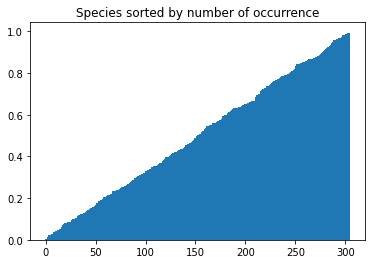

In [75]:
x = [i for i in range(305)]
plt.bar(x, sorted(aa))
plt.title("Species sorted by number of occurrence")

In [79]:

x = [i for i in range(305)]
a = plt.bar(x, sorted(sp_occ, reverse= True), width = 2)
plt.title("Species sorted by number of occurrence")
plt.show()

## Species not present

In [9]:
with open('/network/scratch/t/tengmeli/ecosystem-embedding/songbirds.txt', encoding="utf-8") as f:
    song= f.read().splitlines()

In [10]:
songbirds = sorted(song)

In [11]:
train_y = np.load("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/y_train.npy")
valid_y = np.load("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/y_val.npy")

In [12]:
idx = np.where(train_y.max(axis = 0)==0)[0]
np.array(songbirds)[idx]

array(['Acanthis hornemanni', 'Alauda arvensis', 'Amandava amandava',
       'Bombycilla garrulus', 'Calcarius pictus', 'Copsychus malabaricus',
       'Crithagra mozambica', 'Estrilda astrild', 'Lanius borealis',
       'Leiothrix lutea', 'Lonchura atricapilla',
       'Motacilla tschutschensis', 'Paroaria capitata',
       'Paroaria coronata', 'Phylloscopus borealis', 'Sicalis flaveola'],
      dtype='<U31')

In [13]:
idx = np.where(valid_y.max(axis = 0)==0)[0]
np.array(songbirds)[idx]

array(['Acanthis flammea', 'Acanthis hornemanni', 'Acridotheres tristis',
       'Alauda arvensis', 'Amandava amandava', 'Ammospiza caudacuta',
       'Aphelocoma insularis', 'Artemisiospiza belli',
       'Baeolophus wollweberi', 'Bombycilla garrulus',
       'Calcarius lapponicus', 'Calcarius pictus', 'Camptostoma imberbe',
       'Catharus bicknelli', 'Chamaea fasciata', 'Contopus pertinax',
       'Copsychus malabaricus', 'Crithagra mozambica', 'Cyanocorax yncas',
       'Empidonax fulvifrons', 'Estrilda astrild', 'Icterus graduacauda',
       'Icterus gularis', 'Icterus pectoralis', 'Lanius borealis',
       'Leiothlypis crissalis', 'Leiothrix lutea', 'Leucosticte atrata',
       'Lonchura atricapilla', 'Lonchura punctulata', 'Loxia sinesciuris',
       'Motacilla tschutschensis', 'Myiarchus tuberculifer',
       'Myiodynastes luteiventris', 'Oenanthe oenanthe',
       'Paroaria capitata', 'Paroaria coronata', 'Peucaea botterii',
       'Peucaea carpalis', 'Phylloscopus borealis',

In [14]:
means =  train_y.mean(axis = 0)

In [15]:
most_freq = means.argsort()[-50:][::-1]

In [16]:
most_freq

array([276,   3, 130,  41,  62, 260,  96, 249, 205,  90,  71,  67, 261,
       137, 231,  93, 154,  30, 295, 134, 254, 272, 161, 282, 187, 264,
        26,  60, 141, 101, 292, 243, 257, 193, 165, 179, 240,  63, 211,
       188,  97, 180, 213, 255, 262, 233, 248,  80, 271, 283])

In [17]:
np.array(songbirds)[most_freq[:10]]

array(['Turdus migratorius', 'Agelaius phoeniceus', 'Melospiza melodia',
       'Cardinalis cardinalis', 'Corvus brachyrhynchos',
       'Sturnus vulgaris', 'Hirundo rustica', 'Spinus tristis',
       'Quiscalus quiscula', 'Geothlypis trichas'], dtype='<U31')

In [18]:
less_freq = means.argsort()[:50]

In [19]:
less_freq

array([152,  35,  61,  66,  84, 110, 118, 123, 138,  31, 153,   7,   6,
       174, 241,   1,   2,  33, 256, 147, 304, 186,   0, 119, 302, 105,
        46, 127,  15,  85,  18, 200, 120, 201, 113, 126, 148,  75,  10,
       102, 296,  49, 192, 225, 207, 265, 268, 121, 216,  12])

## Predicting mean 

In [58]:
means = train_y.mean(axis = 0)

In [64]:
means = np.tile(means, (valid_y.shape[0], 1))

In [66]:
mae = np.abs(valid_y-means).mean()
mae

0.04522211284208954

In [83]:
mfmae = np.abs(valid_y[:, most_freq]-means[most_freq]).mean()
lfmae = np.abs(valid_y[:, less_freq]-means[less_freq]).mean()
mfmae, lfmae

(0.1726444460951579, 0.00025060809726513647)

In [82]:
mse = (np.abs(valid_y-means)**2).mean()
mse

0.012486536721184964

In [84]:
mfmse = (np.abs(valid_y[:, most_freq]-means[most_freq])**2).mean()
lfmse = (np.abs(valid_y[:, less_freq]-means[less_freq])**2).mean()
mfmse, lfmse

(0.05166902167065883, 2.6805862418467066e-05)

In [70]:
(np.abs(valid_y)**2).mean()

0.018365347567835803

## Regression

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

gbx = GradientBoostingRegressor(random_state=0)
regr = svm.SVR()
ridge = Ridge(random_state=0)
sgd = SGDRegressor(random_state=0)
mlp = MLPRegressor(random_state=0)

#try different models 
models = [gbx, regr, ridge, sgd, mlp]



In [25]:
mse = []
r2 = []

In [26]:
clfs = []

In [27]:
for model in models[:1] : 
    clf = MultiOutputRegressor(model).fit(X_array, train_y)
    clfs += [clf]
    pred = clf.predict(V_array)
    mse += [mean_squared_error(valid_y, pred)]
    r2 += [clf.score(V_array, valid_y)]

In [14]:
#np.save("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/y_pred.npy", np.array(pred))
#np.save("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/y_val.npy", np.array(valid_y))
#np.save("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/y_train.npy", train_y)
#np.save("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/X_val.npy", V_array)
#np.save("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/X_train.npy", X_array)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/mila/t/tengmeli/.conda/envs/ebird-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-6524109c1c8b>", line 1, in <module>
    np.save("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/y_pred.npy", np.array(pred))
NameError: name 'pred' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mila/t/tengmeli/.conda/envs/ebird-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mila/t/tengmeli/.conda/envs/ebird-env/lib/python3.6/site-packages/IPython/core/ultratb.py", line

TypeError: object of type 'NoneType' has no len()

In [25]:
import numpy as np

In [26]:
pred = np.load("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/y_pred.npy")
gt = np.load("/home/mila/t/tengmeli/ecosystem-embedding/predictions/GBR/y_val.npy")

In [29]:
mae = np.abs(pred-gt).mean()
mae

0.032430692542710644

In [28]:
mse = (np.abs(pred-gt)**2).mean()
mse

0.008270733667620472

In [34]:
mfmae = np.abs(pred[:, most_freq]-gt[:,most_freq]).mean()
mfmae

0.12384799276760736

In [35]:
mfmse = (np.abs(pred[:, most_freq]-gt[:,most_freq])**2).mean()
mfmse

0.03311782936754792

In [33]:
mfmae = np.abs(pred[:, most_freq]-gt[:,most_freq]).mean()
#lfmae = np.abs(valid_y[:, less_freq]-means[less_freq]).mean()
mfmae#, lfmae

0.12384799276760736

In [5]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from src.losses.metrics import validate_labels,validate_top_k_sets, predict_top_k_set, top_k_error_rate_from_sets, top_k_error_rate



## plot top k metric

In [54]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [48]:
k = 20

In [49]:
top_k_pred = predict_top_k_set(pred, k)
top_k_gt= predict_top_k_set(gt, k)

score = []
for k in range(1, 300, 5):
    top_k_pred = predict_top_k_set(pred, k)
    top_k_gt= predict_top_k_set(gt, k)
    per_hs = (np.expand_dims(top_k_gt, -1) == np.expand_dims(top_k_pred, 1))
    per_hs = (per_hs.sum(axis=-1).sum(axis=-1))/k
     score += [per_hs.mean()]

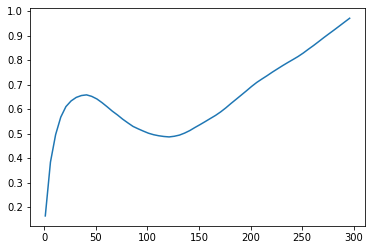

In [55]:
plt.scatter(range(1, 300, 5), score)

In [19]:
mse

[0.008270733667620468,
 0.015796465345222502,
 0.009368097642343571,
 5.821019049850307e+31,
 5.337575518145899]

In [17]:
r2

[-1.9580787770466195,
 -434.98624162427797,
 -0.3311816910651332,
 -3.448668894638079e+36,
 -216468.1455196927]

## Classification (target 0-1)

In [70]:
ty = train_y.copy()
ty[ty>0] = 1
ty[ty==0] = 0
#ty = ty.astype(np.uint8)

In [71]:
vy = valid_y.copy()
vy[vy>0] = 1
vy[vy==0] = 0
#vy = vy.astype(np.uint8)

In [26]:
from scipy import sparse

In [28]:
vy_sparse = sparse.csr_matrix(vy)
ty_sparse = sparse.csr_matrix(ty)

In [178]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
clf = multi_target_forest.fit(X_array, ty)
pred = clf.predict(V_array)

In [ ]:
mean_absolute_error(vy, pred)

In [109]:
np.mean(np.mean(pred == vy, axis=1))

0.9357057177129149

In [102]:
np.abs(pred-vy).sum(axis = 1).mean()

19.609756097560975

In [96]:
probs = clf.predict_proba(V_array)

In [133]:
elem = probs[0]

In [139]:
cross = []
for i,elem in enumerate(probs):
    elem[elem==1] = 0.999
    elem[elem==0] = 0.001
    if elem.shape[1] == 2:
        a = -vy[:,0] * np.log(elem[:,0]) - (1-vy[:,0]) * np.log(1 - elem[:,0])
        cross += [a.sum()]

In [143]:
np.array(cross).sum() / (451*305)

4.663170316732171

In [1]:
from pathlib import Path
import pandas as pd
import json

In [2]:
train = pd.read_csv("/network/projects/ecosystem-embeddings/ebird_dataset/USA_summer/summer_hotspots_train.csv")

In [3]:
root = Path("/network/projects/_groups/ecosystem-embeddings/ebird_dataset/USA_summer/targets")

In [5]:
i = 0

In [11]:
u = train.iloc[i]["hotspot_id"]

In [12]:
with open(root/ f"{u}.json", "r") as s:
    spe = json.load(s)


In [9]:
f"{(train.iloc[i]["hotspot_id"])}.json"

SyntaxError: f-string: unmatched '[' (3409208719.py, line 1)